In [19]:
#this is bare bones... just easy to run to make figures
#has some Isaac specific file naming conventions and stuff like that...
#probably easy to modify, but might need to dig a little to figure out - reference polka dot code for help.

In [20]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib.ticker import MaxNLocator
%matplotlib inline
params ={'mathtext.default':'regular'}          
plt.rcParams.update(params)
tnr="Times New Roman"
tnrb="Times New Roman Bold"

In [21]:
#Here we define all manually named variables you will need to call later
#I've done some trickery using my file naming format so that I only need to update a few things.

#UPDATE ME
obsID = 'TESTID'
dataset = 'chandra' #replace with 'chandra' or 'xmm'
exposure = 67740
bin = 'TESTbin'
abund = 'TESTabund'
heii = 'TESTheii'
date = 'TESTdate'

#FILES
filename = "zpup_%s_%s_%s_%s_%s.dat" %(obsID,bin,abund,heii,date)
kapfile = "kappaZ_%s_%s_%s_%s.txt" %(obsID,bin,abund,heii)

lines = "zpup_lines_%s.txt" %(dataset)

#PLOT TEXT
if bin == 'grp30': binsize = '30 counts/bin'
elif bin == 'grp10': binsize = '10 counts/bin'
else: binsize = 'some binsize'

if abund == 'martins': abundance = 'Martins et al. (2015) abundances'    
elif abund == 'herve':abundance = 'Herve et al. (2013) abundances'    
else: abundance = 'some abundance'

if dataset=='chandra':
    spec1 = 'MEG'
    spec2 = 'HEG'
elif dataset=='xmm':
    spec1 = 'RGS1'
    spec2 = 'RGS2'

#PARAMETERS
params = 'false' #make = 'true' or 'false' to turn parameter display on/off

kT = "0.110, 0.187, 0.318,\n0.540, 0.919, 1.56"
norms = "0, 1891, 756.5, 109.3, 65.6, 7.04"
vel = "813.54"
z = r'${-1.31\times10^{-3}}$'
sigma_star = r'${4.34\times10^{-2}}$'

total_bins = "79"
c_stat = "111.72"

#SAVE FILE NAMES
savefile = 'false' #again, set true/false to save/not save

spec1dot_name = "zpup_%s_%s_%s_%s_%sdots.png" %(obsID,bin,abund,heii,spec1)
spec2dot_name = "zpup_%s_%s_%s_%s_%sdots.png" %(obsID,bin,abund,heii,spec2)
dot_name = "zpup_%s_%s_%s_%s_dots.png" %(obsID,bin,abund,heii)

spectra1_name = "zpup_%s_%s_%s_%s_%sspectra.jpg" %(obsID,bin,abund,heii,spec1)
spectra2_name = "zpup_%s_%s_%s_%s_%sspectra.jpg" %(obsID,bin,abund,heii,spec2)

kappa_name = "opacity_zpup_%s_%s_%s_%s.png" %(obsID,bin,abund,heii)

#OTHER PLOT TEXT (only needs to be changed if not working on zeta pup / Chandra data)
starname='$\\zeta$ Pup'
starnum=0 #for now, need this (zeta Pup designation) to make some of W's functions work
star='zpup'

In [22]:
#defining some functions to use later
def read_dat_file(filename):
    """
    Specialized function for reading .dat files and outputting a 3-tiered
    list (described below).
    """
    datfile = open(filename, "r")
    line = datfile.readline().strip()
    
    #skipping header
    while line[0] not in "0123456789":
        line = datfile.readline().strip()   
    """
    a 2-tiered list:
    tier 1: the data set (MEG or HEG)
    tier 2: 0   central wavelength in angstroms
            1   half-width of bin
            2   data value, in counts/sec/angstrom
            3   formal uncertainty, same units
            4   model 
    """   
    data = []
    eg = [[],[],[],[],[]] #to hold MEG, then HEG, as we go through appending
    while line != "": #until end of file, keep reading

#if we find a divider (the NO NO NO NO NO line), then append MEG data to data list and reset eg
#to hold HEG data
        if line[0] == "N":
            data.append(eg)
            eg = [[],[],[],[],[]]
        
        else:
            line = line.split(" ") #otherwise, split line into list of strings
            eg[0].append(float(line[0])) #append float of wavelength to wavelength list
            eg[1].append(float(line[1])) #append half bin width
            eg[2].append(float(line[2])) #append data value
            eg[3].append(float(line[3])) #append error bar value
            eg[4].append(float(line[4])) #append model value

        
        #grab the next line
        line = datfile.readline().strip()
    
    #at end of file, append HEG data to data list
    data.append(eg)

    if data[0][0][0] > data[0][0][1]: #if MEG data in order of decreasing wavelength
        for i in range(5):
            data[0][i].reverse() #reverse order
    if data[1][0][0] > data[1][0][1]: #if HEG data in order of decreasing wavelength
        for i in range(5):
            data[1][i].reverse() #reverse order
    return data

def read_kappaZ_file(filename):
    """
    Specialized function for reading .txt kappaZ files and outputting a
    list (described below).
    """
    datfile = open(filename, "r")
    line = datfile.readline().strip()
    
    #if/elif/else statement which checks if the kappaZ file has 2 or 3 columns(i.e. if the HEII switch was on or off)
    if len(line.split('\t'))==3:
        
        #skipping header
        while line[0] not in "0123456789":
            line = datfile.readline().strip() 
        """
        a list: 0   central wavelength in keV
                1   kappa in cm**2 g**-1
                2   not really sure... something to do with HEII switch?
        """  
        kapdata = [[],[],[]]
        while line != "": #until end of file, keep reading
        
            line = line.split("\t") #otherwise, split line into list of strings
            kapdata[0].append(float(line[0])) #append float of energy to energy list
            kapdata[1].append(float(line[1])) #append kappa
            kapdata[2].append(float(line[2])) #append HEII column
            
            #grab the next line
            line = datfile.readline().strip()           
    elif len(line.split('\t'))==2:    
        while line[0] not in "0123456789":
            line = datfile.readline().strip()
            """
            a list: 0   central wavelength in keV
                    1   kappa in cm**2 g**-1
            """  
        kapdata = [[],[]]
        while line != "": #until end of file, keep reading
        
            line = line.split("\t") #otherwise, split line into list of strings
            kapdata[0].append(float(line[0])) #append float of energy to energy list
            kapdata[1].append(float(line[1])) #append kappa
                
            #grab the next line
            line = datfile.readline().strip()
    else: print("incorrect file format")
             
    return kapdata

def histogram_data(data):
    """
    Takes a data set and returns a data set that will produce a histogram.
    This involves, essentially, doubling the size of the model. Instead
    of plotting each value once at the center of the bin, we want to plot
    twice on either side of the bin.
    """
    #each of these has two parts: one for the first data set,
    #one for the second
    histwvs = [[],[]]
    histmods = [[],[]]
    histvals = [[],[]]
    
    for i in range(len(data)):
        for j in range(len(data[i][1])):
            histwvs[i].append(data[i][0][j]-data[i][1][j]) #append left wavelength of bin
            histwvs[i].append(data[i][0][j]+data[i][1][j]) #append right wavelength of bin
            histvals[i].append(data[i][2][j]) #append data value twice. This actually isn't necessary for any of these
            #plots, so you can delete it if you want.
            histvals[i].append(data[i][2][j])
            histmods[i].append(data[i][4][j]) #append model value twice
            histmods[i].append(data[i][4][j])
    return histwvs,histvals,histmods

#Poisson errors, to replace default xspec errors
def poisson_error(data,exposure_time):
    poisson_errs = [[],[]]

    for i in range(len(data)):
        for j in range(len(data[i][0])):
            count=data[i][2][j]*exposure_time*2*data[i][1][j]
            if count < 0:
                count = 0
            one_err=(count**0.5)/(exposure_time*2*data[i][1][j])
            poisson_errs[i].append(one_err)

    return poisson_errs

In [23]:
#reading data
data = read_dat_file(filename)
histwvs,histvals,histmods = histogram_data(data)

spec1_wvs = data[0][0]
spec1_bins = data[0][1]
spec1_vals = data[0][2]
spec1_errs = data[0][3]
spec1_mods = data[0][4]
spec1_poisson = poisson_error(data,exposure)[0]
    
spec2_wvs = data[1][0]
spec2_bins = data[1][1]
spec2_vals = data[1][2]
spec2_errs = data[1][3]
spec2_mods = data[1][4]
spec2_poisson = poisson_error(data,exposure)[1]

#reading kappaZ data
kapdata = read_kappaZ_file(kapfile)

#defining the elements of data in the case of 2 or 3 columns
if len(kapdata)==3:
    keV = np.asarray(kapdata[0]) #still in keV, we will convert to angstrom when we plot
    Kappa = np.asarray(kapdata[1])
    HEII = np.asarray(kapdata[2])
    Kap_HEII = Kappa+HEII
else:
    keV = np.asarray(kapdata[0]) #still in keV, we will convert to angstrom when we plot
    Kappa = np.asarray(kapdata[1])

#lines names, centers, and temps
ll_filename =lines
line_names = np.loadtxt(ll_filename, dtype=type(""),usecols=(0)) #load line names into list
line_locs = np.loadtxt(ll_filename,usecols=(1)) #load line locations into list
line_temps = np.loadtxt(ll_filename, usecols=(2)) #load line temps into list. Temps are in Kelvin, not keV

#MEG boundaries
mline_locations = np.loadtxt(ll_filename, usecols=(3,4)) #load line wavelengths into list
m_cls = np.loadtxt(ll_filename, usecols=(5,6)) #load continuum boundaries into list

#HEG boundaries
hline_locations= np.loadtxt(ll_filename, usecols=(7,8))
h_cls = np.loadtxt(ll_filename, usecols=(9,10)) #load continuum boundaries into list

#combining MEG and HEG
cont_locations=[m_cls,h_cls]
line_locations=[mline_locations,hline_locations]

In [24]:
#Functions that will calculate numbers needed for the ratios we're plotting

def integrate_continuum(data, dnum, xmin, xmax, cnmin, cnmax,xnmin,xnmax):
    """
    Returns parameters for continuum's slope-intercept form (y=mx+b) and 
    the integrated total under the continuum for both the data and model.
    Parameters passed in are:
    <data>: the 3-tier data structure
    <dnum>: the data set number (first index of 3-tier structure)
    <xmin> & <xmax>: the range of the line given in the line list file
    <cnmin> & <cnmax>: the indices for the short- and long-wavelength bins
        nearest to the line that are entirely in the continuum
    <xnmin> & <xnmax>: must be parameters I used previously. It should be okay to remove them.
    """   
                
    #the appropriate values to find our m and b values for a linear continuum fit

    x1 = data[dnum][0][cnmin]
    x2 = data[dnum][0][cnmax]
    y1dat = data[dnum][2][cnmin]
    y2dat = data[dnum][2][cnmax]
    y1mod = data[dnum][4][cnmin]
    y2mod = data[dnum][4][cnmax]
    
    mdat = (y2dat - y1dat) / (x2 - x1)
    bdat = -mdat * x1 + y1dat
    mmod = (y2mod - y1mod) / (x2 - x1)
    bmod = -mmod * x1 + y1mod
    
    int_cont_dat=(.5*mdat*(xmax**2)+bdat*xmax)-(.5*mdat*(xmin**2)+bdat*xmin) #integrated area under data continuum
    int_cont_mod=(.5*mmod*(xmax**2)+bmod*xmax)-(.5*mmod*(xmin**2)+bmod*xmin) #integrated area under model continuum
    
    return (mdat, bdat, int_cont_dat), (mmod, bmod, int_cont_mod)

def find_cont(data, dnum, umin, umax):
    """
    Returns the indices of the bins for the short- and long-wavelength bins
        nearest to the line in question that are entirely in the continuum
    Parameters:
    <data>: the 3-tier data structure
    <dnum>: the data set number (first index of 3-tier structure)
    <xmin> & <xmax>: the range of the line given in the line list file
    If we run into any issues (like the line not existing in this dataset),
        null values are returned.
    """
    cdata = data[dnum] #cdata for current data (i.e. MEG or HEG)
    d_len = len(cdata[0]) #to avoid index errors
    
    n1 = 0
    found1 = False
    while not found1 and n1 < d_len: #index through to find bin just before left range of line
        if cdata[0][n1]+cdata[1][n1] < umin: #if not found, move to next bin
            n1+=1 
        else:
            n1-=1 #found bin containing left of line, so subtract 1 from n1 and exit loop
            if n1 < 0:
                return None, None #if left range in first bin of entire dataset, return None
            found1 = True
    
    if n1 == d_len: #if end of data reached, return None
        return None, None
    
    n2 = n1 + 1
    found2 = False
    while not found2 and n2 < d_len: #index through to find bin containing right end of line
        if cdata[0][n2]-cdata[1][n2] < umax: #if not found, move to next bin
            n2+=1 
        else:
            found2 = True #found bin just right of right end, so exit loop
    
    if n2 == d_len: #if end of data reached, return None
        return None, None #this is returning "None" for the later line and makes an error.
    
    return n1, n2

def integrate_line(data, dnum, xmin, xmax, xnmin, xnmax, int_type):
    """
    Integrates (rectangularly) the data or model over the specified line.
    Parameters:
    <data>: the 3-tiered data structure
    <dnum>: the data set number (0 for MEG or 1 for HEG)
    <xmin> & <xmax>: the range of the line given in the line list file
    <xnmin> & <xnmax>: the two indices that correspond to bins entirely 
                     outside the line
    <int_type>: whether this should integrate the data or the model
    """
    cdata = data[dnum] #cdata for current data

    if int_type.lower() == "data":
        int_ind = 2
    elif int_type.lower() == "model":
        int_ind = 4
    else:
        raise Exception("Parameter <int_type> must be 'data' or 'model'.")
        
    if xnmin==xnmax: #if xmin and xmax in same bin
        binw=xmax-xmin
        y=cdata[int_ind][xnmin]
        total_int=binw*y

    else:
        #find widths of first and end partial bins as before
        binw_0=cdata[0][xnmin]+cdata[1][xnmin]-xmin
        binw_end=xmax-(cdata[0][xnmax]-cdata[1][xnmax])

        #find model or data yval for each partial bin
        y_0=cdata[int_ind][xnmin]
        y_end=cdata[int_ind][xnmax]

        #multiply yvals by bin widths and add the products to the integral
        total_int=binw_0*y_0+binw_end*y_end
        
        #for all full bins between partial bins
        for i in range(xnmin+1,xnmax):
            #multiply yval by bin width and add to integral
            total_int+=cdata[int_ind][i]*2*cdata[1][i]

    return total_int

def line_ratio(data, dnum, line_names, line_locations, cont_locations):
    """
    Creates <int_tot> to keep track of the information about each line.
    
    Structure of <int_tot>
    0:    line name
    1&2:  xmin & xmax
    3&4:  the continuum-subtracted integrals of the data and model, respectively
    5&6:  the slope and y-intercept, respectively, of the 
          continuum line fitted to the data
    7&8:  the slope and y-intercept, respectively, of the 
          continuum line fitted to the model
    9&10: xnmin & xnmax
    11:   the ratio of data-to-model flux
    12&13:cnmin and cnmax
    """
    int_tot = []

    for i in range(len(line_locations)):
        xmin = line_locations[i][0]
        xmax = line_locations[i][1]
        cmin=cont_locations[i][0]
        cmax=cont_locations[i][1]
#DHC 19jan22        print(xmin, xmax, cmin, cmax)
        cnmin, cnmax = find_cont(data, dnum, cmin, cmax) #TRACE error
        #print(cnmin)
        #print(cnmax)#used for TROUBLESHOOTING
        xnmin,xnmax=find_cont(data,dnum,xmin,xmax)
        if xnmin == None or cnmin == None: #ie if line isn't in dataset
            int_tot.append([line_names[i], xmin, xmax, None, None, None, None, \
                           None, None, None])
        else:
            xnmin+=2
            xnmax-=2
            #integrate continuum
            dat_cont, mod_cont = integrate_continuum(data, dnum, xmin, xmax, \
                                                     cnmin, cnmax,xnmin,xnmax) #TRACE
            #integral of the line is the integral of the data or model minus the appropriate continuum
            dat_line = integrate_line(data, dnum, xmin, xmax, \
                                     xnmin, xnmax, "data") - dat_cont[2]
            mod_line = integrate_line(data, dnum, xmin, xmax, \
                                     xnmin, xnmax, "model") - mod_cont[2]
            #add all the information to <int_tot>
            int_tot.append([line_names[i], xmin, xmax, dat_line, mod_line, \
                           dat_cont[0], dat_cont[1], mod_cont[0], mod_cont[1], \
                           xnmin, xnmax, mod_line/dat_line,cnmin,cnmax])
    return int_tot

In [25]:
ratios=[[],[]]

#for plotting MEG line ratios
int_tot0 = line_ratio(data, 0, line_names, line_locations[0],cont_locations[0])

#for plotting HEG line ratios
int_tot1 = line_ratio(data, 1, line_names, line_locations[1],cont_locations[1])

In [26]:
#little function needed for the line counts
def none_to_zero(x):
    if x == None:
        return 0.0
    else:
        return x

#polka dot plot creating function (works for HEG or MEG, not the combo)
def polkadot(inttot, spectra, filename):
    line_counts = [none_to_zero(inttot[i][3]) for i in range(len(inttot))] #continuum-subtracted data integral
    max_line = max(line_counts)
    x = []
    y = []
    sizes = []
    label = []
    color = []
    plt.rcParams['figure.figsize'] = (7,4)
    fig, ax = plt.subplots()
    for i in range(len(inttot)):
        if inttot[i][3]!=None: #as long as the line is present in the data
            if inttot[i][11]>0 and inttot[i][11]<2.25: #if data-to-model flux ratio is positive and not one of the few outliers
                x.append(line_locs[i]) #add x-coordinates to list
                y.append(inttot[i][11]) #add y-coordinates to list
                sizes.append(300*inttot[i][3]/max_line) #dot area is proportional to number of counts in line
                label.append(inttot[i][0]) #add line label
                color.append(line_temps[i]/1e6) #add color for line temperature
            if inttot[i][11]>2.25: print('WARNING: %s (%s Å) flux ratio >2.25' %(line_names[i],line_locs[i])) #alerting if a dot is off the graph
            if inttot[i][11]<0.45: print('WARNING: %s (%s Å) flux ratio <0.45' %(line_names[i],line_locs[i]))
        
    cplot=ax.scatter(x, y,s=sizes,c=color,cmap=mp.colormaps['cool_r'])
    for i, txt in enumerate(label):
        ax.annotate(txt, (x[i],y[i]*1.03))

    
    plt.axhline(y=1, color='k', linestyle='--',linewidth=0.5) #line for perfect ratio of 1
    plt.axhline(y=0.8, color='gray', linestyle='--',linewidth=0.5) #lines for +/-25% difference from ratio of 1
    plt.axhline(y=1.25, color='gray', linestyle='--',linewidth=0.5)
    plt.xlabel("Wavelength (Å)",fontsize=15,fontname=tnr)
    plt.ylabel("Model-to-Data Flux Ratio",fontsize=15,fontname=tnr)
    
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.set_yticks([.5,.8,1.0,1.25,2.0])
    ax.set_yticklabels(['0.5','0.8','1.0','1.25','2.0'],fontname=tnr,fontsize=15)
    plt.xlim(5,max(histwvs[0])*1.1)
    plt.ylim(.4,2.5)
    plt.xticks(fontname=tnr,fontsize=15)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.text(6,2,"%s %s %s\n%s, %s" %(starname, obsID, spectra, binsize, heii),fontsize=12,fontname=tnr)
    plt.tight_layout(pad=1)
    im=ax.scatter(x,y,s=sizes,c=color,cmap=mp.colormaps['cool_r'],vmin=1,vmax=10)

    cbar=fig.colorbar(im,ax=ax,ticks=[2,4,6,8,10],cmap="cool_r")
    cbar.ax.set_yticklabels(["2", '4', '6','8','10'],fontname=tnr)

    if filename and savefile == 'true': plt.savefig(filename)
    
    plt.show()
    

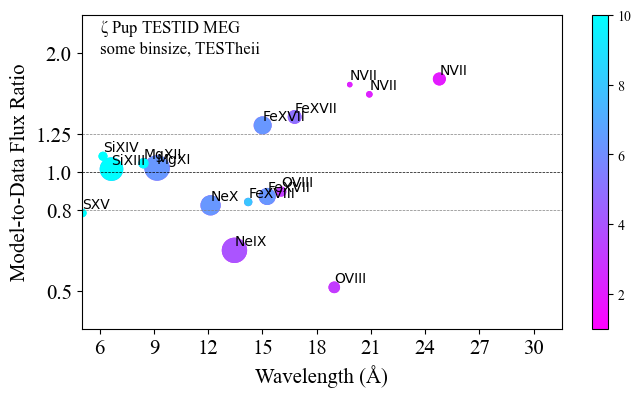

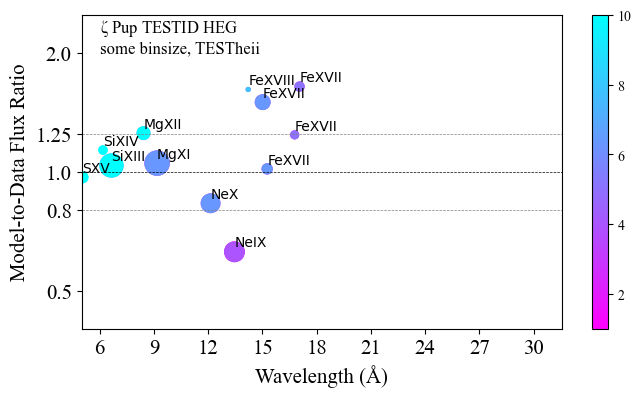

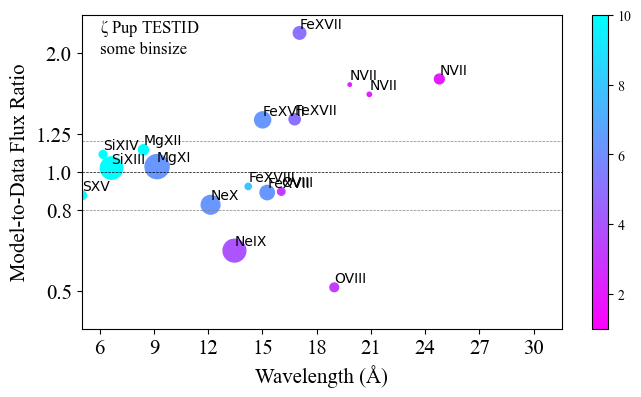

In [27]:

#plotting MEG/RGS1 polka dot plot
polkadot(int_tot0, spec1, filename=spec1dot_name)

#plotting HEG/RGS2 polka dot plot
polkadot(int_tot1, spec2, filename=spec2dot_name)

#combined spectra 1 and spectra 2 polka dot plot
#MEG/RGS1 data
line_counts0 = [none_to_zero(int_tot0[i][3]) for i in range(len(int_tot0))] #continuum-subtracted data integral
# HEG/RGS2 data
line_counts1 = [none_to_zero(int_tot1[i][3]) for i in range(len(int_tot1))]
# calculate and plot the combined ratios
weighted_ratios = [] #we do (MEG model + HEG model)/(MEG data + HEG data) instead of (MEG ratio + HEG ratio)/2
for i in range(len(int_tot0)):
    if int_tot0[i][3] == None and int_tot1[i][3] == None:
        weighted_ratios.append(None)
    elif int_tot0[i][3] == None:
        weighted_ratios.append(int_tot1[i][4]/int_tot1[i][3])
    elif int_tot1[i][3] == None:
        weighted_ratios.append(int_tot0[i][4]/int_tot0[i][3])
    else:
        total_data = int_tot0[i][3]+int_tot1[i][3]
        total_model = int_tot0[i][4]+int_tot1[i][4]
        weighted_ratios.append(total_model/total_data)
combined_flux = []
for i in range(len(int_tot0)):
    if int_tot0[i][3] == None and int_tot1[i][3] == None:
        combined_flux.append(0)
    elif int_tot0[i][3] == None:
        combined_flux.append(int_tot1[i][3])
    elif int_tot1[i][3] == None:
        combined_flux.append(int_tot0[i][3])
    else:
        combined_flux.append(int_tot0[i][3]+int_tot1[i][3])
max_line2 = max(combined_flux)
plt.rcParams['figure.figsize'] = (7,4)
fig, ax = plt.subplots()
x = []
y = []
sizes = []
label2 = []
color = []
for i in range(len(int_tot1)):
    if int_tot1[i][3] != None or int_tot0[i][3] != None:
        if weighted_ratios[i]>0 and weighted_ratios[i]<2.25:
            x.append(line_locs[i])
            y.append(weighted_ratios[i])
            sizes.append(300*combined_flux[i]/max_line2)
            label2.append(int_tot0[i][0])
            color.append(line_temps[i]/1e6)
        if weighted_ratios[i]>2.25: print('WARNING: %s (%s Å) flux ratio >2.25' %(line_names[i],line_locs[i])) #alerting if a dot is off the graph
        if weighted_ratios[i]<0.45: print('WARNING: %s (%s Å) flux ratio <0.45' %(line_names[i],line_locs[i]))

for i, txt in enumerate(label2):
    ax.annotate(txt, (x[i],y[i]*1.03))
im=ax.scatter(x,y,s=sizes,c=color,cmap=mp.colormaps['cool_r'],vmin=1,vmax=10)
plt.axhline(y=1, color='k', linestyle='--',linewidth=0.5)
plt.axhline(y=0.8, color='gray', linestyle='--',linewidth=0.5)
plt.axhline(y=1.2, color='gray', linestyle='--',linewidth=0.5)
plt.xlabel("Wavelength (Å)",fontsize=15,fontname=tnr)
plt.ylabel("Model-to-Data Flux Ratio",fontsize=15,fontname=tnr)
ax.set_yscale('log')
plt.xticks(fontname=tnr,fontsize=15)
ax.yaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.set_yticks([.5,.8,1,1.25,2.0])
ax.set_yticklabels(['0.5','0.8','1.0','1.25','2.0'],fontname=tnr,fontsize=15)
plt.ylim(.4,2.5)
plt.xlim(5,max(histwvs[0])*1.1)
plt.xticks(fontname=tnr,fontsize=15)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.text(6,2,"%s %s\n%s" %(starname, obsID, binsize),fontsize=12,fontname=tnr)
plt.tight_layout(pad=1)

cbar=fig.colorbar(im,ax=ax,ticks=[2,4,6,8,10],cmap="cool_r")
cbar.ax.set_yticklabels(["2", '4', '6','8','10'],fontname=tnr)

if savefile =='true':
    plt.savefig(dot_name)
plt.show()

In [28]:
#Making the main opacity plots function
def opacvslambda(dat):
    #if/else statement for when there is 2 or 3 columns
    if len(dat)==3:
        plt.rcParams['figure.figsize'] = (11.25, 6.0)
        plt.plot(12.398/keV, Kappa, label='without He II opacity') #12/398/keV converts to angstroms

        #plotting opacity+HEII column vs wavelength
        plt.plot(12.398/keV, Kap_HEII, label='with He II opacity') #12/398/keV converts to angstroms

        plt.xlim(4,30)
        ymin_ind = int(np.where(keV == 0.4313)[0]) #auto restricts the y-range to kappa's max value within the 4-30 angstrom bounds
        ymax_ind = int(np.where(keV == 3.2345)[0])
        plt.ylim(-10,Kap_HEII[ymin_ind:ymax_ind].max()*1.25)

        plt.text(5, Kap_HEII[ymin_ind:ymax_ind].max(),'%s %s\n%s'%(starname,obsID,abundance),fontsize=18,fontname=tnr)
        plt.xlabel("Wavelength (Å)",fontsize=18,fontname=tnr)
        plt.ylabel("Opacity (cm$^{2}$ g$^{-1}$)",fontsize=18,fontname=tnr)
        plt.xticks(fontname=tnr)
        plt.yticks(fontname=tnr)
        plt.tick_params(labelsize=15)
        plt.legend()
        
        if savefile =='true':plt.savefig(kappa_name)
        plt.show()     
    else:        
        plt.rcParams['figure.figsize'] = (11.25, 6.0)
        plt.plot(12.398/keV, Kappa, label='no He II opacity') #12/398/keV converts to angstroms
        
        plt.xlim(4,30)
        ymin_ind = int(np.where(keV == 0.4313)[0]) #auto restricts the y-range to kappa's max value within the 4-30 angstrom bounds
        ymax_ind = int(np.where(keV == 3.2345)[0])
        plt.ylim(-10,Kappa[ymin_ind:ymax_ind].max()*1.25)
        
        plt.text(5, Kappa[ymin_ind:ymax_ind].max(),'%s %s\n%s'%(starname,obsID,abundance),fontsize=18,fontname=tnr)
        plt.xlabel("Wavelength (Å)",fontsize=18,fontname=tnr)
        plt.ylabel("Opacity (cm$^{2}$ g$^{-1}$)",fontsize=18,fontname=tnr)
        plt.xticks(fontname=tnr)
        plt.yticks(fontname=tnr)
        plt.tick_params(labelsize=15)
        plt.legend()

        if savefile=='true': plt.savefig(kappa_name)
        plt.show()

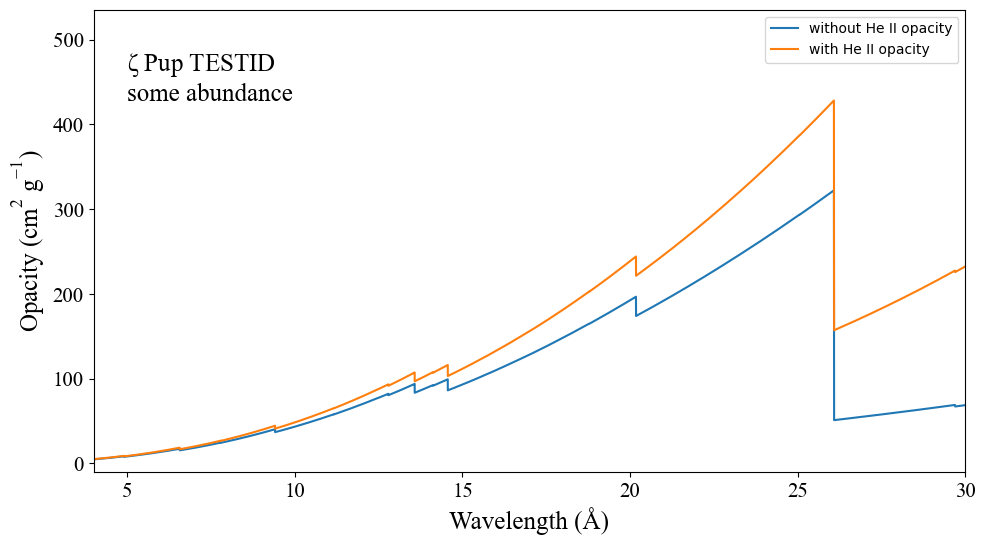

In [29]:
#creating opacity plot
opacvslambda(kapdata)

In [30]:
#defining the plotting spectra function
def plotspectra(spectra, wvs, vals, bins, errs, Histwvs, Histmods, savefile_name):
    plt.rcParams['figure.figsize'] = (11.25, 6.0)
    fig, ax = plt.subplots()

    #different colors depending on spectra
    if spectra==spec1:
        ax.plot(Histwvs, Histmods, color='tab:brown', linewidth=3)
        ax.errorbar(wvs, vals, xerr=bins, yerr=errs, fmt='.', alpha=0.4, color='steelblue', linewidth=1.5)
    else:
        ax.plot(Histwvs, Histmods, color='sandybrown', linewidth=3)
        ax.errorbar(wvs, vals, xerr=bins, yerr=errs, fmt='.', alpha=0.4, color='darkslategray', linewidth=1.5)

    #x boundaries
    lowbound = 4.5  #default
    highbound = max(wvs)
    #OR
    #lowbound = 20  #custom
    #highbound = 23

    #finding the index of low and high bounds
    for i in range(len(wvs)):
        if wvs[i]<lowbound: continue
        if wvs[i]>=lowbound: 
            lowind = i
            break 
        elif i==len(wvs):lowind = i-1 
    for i in range(len(wvs)):
        if wvs[i]<highbound: continue
        if wvs[i]>=highbound:
            highind = i
            break
        else: highind = i

    #setting axis ranges
    plt.xlim(lowbound,highbound)
    ymin = -max(vals[lowind:highind])*0.05
    ymax = max(vals[lowind:highind])*1.3
    plt.ylim(ymin, ymax)

    
    #uses the emission line .txt file to add markers/labels to the lines.
    for i in range(len(line_locs)):
        if line_locs[i]>highbound: continue  #skips lines outside the wavelength bounds
        if line_locs[i]<lowbound: continue   
        if abs(line_locs[i]-line_locs[i-1])<0.3 and line_names[i]==line_names[i-1]:  #takes the label away from lines that are too close together
            plt.vlines(line_locs[i],ymin*0.3,ymax*0.95,linestyle='dashed',color='pink')
            continue     
        plt.vlines(line_locs[i],ymin*0.3,ymax*0.95,linestyle='dashed',color='pink')
        plt.text(line_locs[i]+0.07,ymax*0.86, line_names[i],fontname=tnr,rotation='vertical')

    #figure text and formatting
    plt.title("%s %s, %s, %s, %s" %(starname,obsID,spectra,binsize,abundance),fontname=tnr,fontsize=20)
    plt.xlabel("Wavelength (Å)",fontsize=18,fontname=tnr)
    plt.ylabel("Counts (s$^{-1}$ Å$^{-1})$",fontsize=18,fontname=tnr)
    plt.xticks(fontname=tnr)
    plt.yticks(fontname=tnr)
    plt.tick_params(labelsize=16)
    if params=='true':
        fig.text(0.92,0.4, 'kT$_{1-6}$ (keV) = %s\nnorm$_{1-6}$ = %s\nvelocity = %s\n'
                'z = %s\n$\Sigma_*$ = %s\n\ntotal bins = %s\nC statistic = %s'
                 %(kT,norms,vel,z,sigma_star,total_bins,c_stat)
                ,fontsize=14, fontname=tnr, bbox=dict(facecolor='white', alpha=0.5))
   
    if savefile_name and savefile=='true': plt.savefig(savefile_name, bbox_inches='tight')
    
    plt.show()

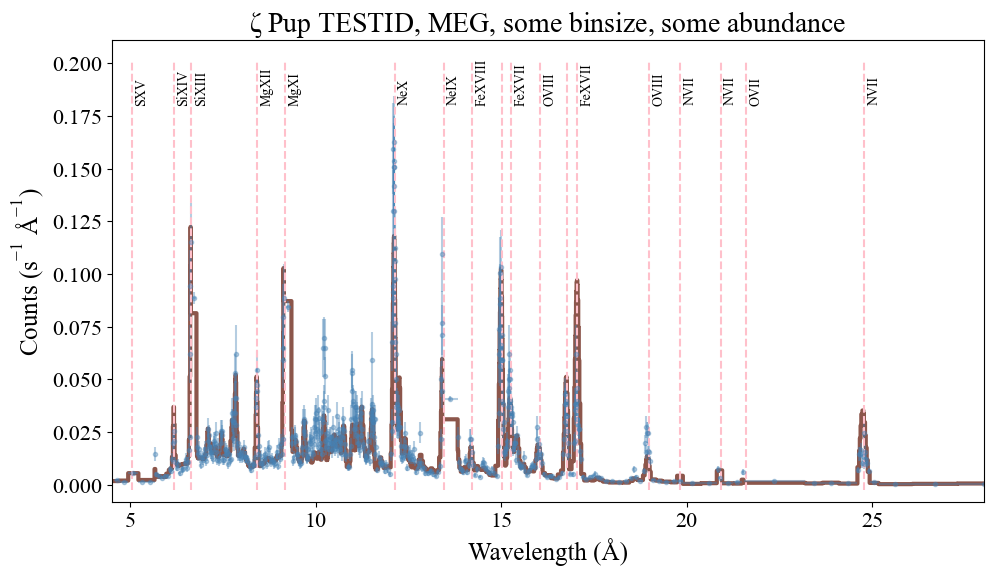

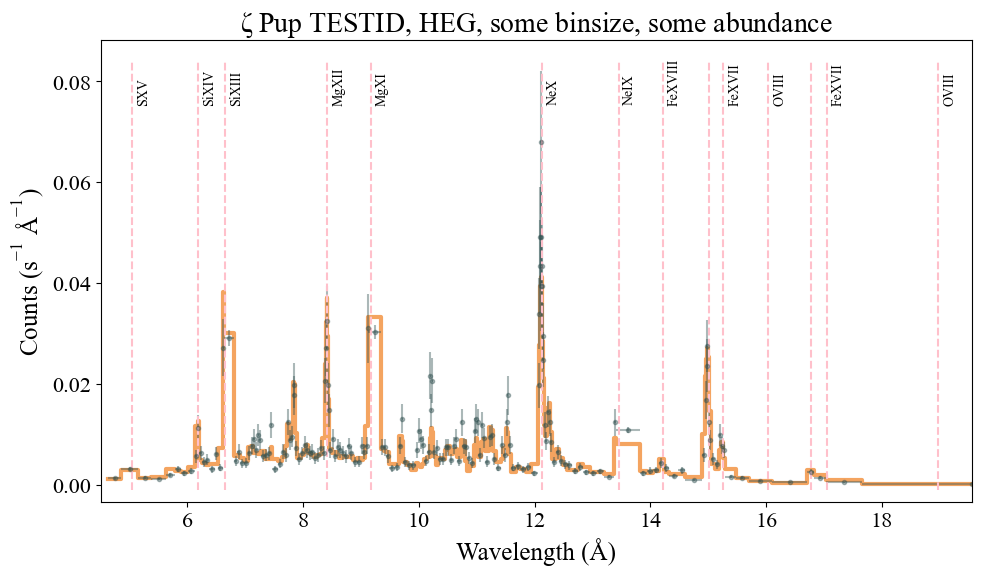

In [31]:
#plotting MEG/RGS1 data
plotspectra(spec1, spec1_wvs, spec1_vals, spec1_bins, spec1_poisson, histwvs[0], histmods[0], savefile_name=spectra1_name)

#plotting #HEG/RGS2 data
plotspectra(spec2, spec2_wvs, spec2_vals, spec2_bins, spec2_poisson, histwvs[1], histmods[1], savefile_name=spectra2_name)